In [11]:
import matplotlib.pyplot as plt
import matplotlib
# %matplotlib qt

import numpy as np
from numpy import *
from scipy.fft import fft, ifft, fftshift, ifftshift
from scipy.optimize import curve_fit

import os
import scipy.io as sio

In [12]:
initial_folder = r'C:\Users\Demag\PycharmProjects\ColdMeasurements\DeMag\DATA\TWPA_noise_6'

folders = os.listdir(initial_folder)
for i in range(len(folders)):
    if ".fig" in folders[i]: pass
    else: 
        print(r"[%d]" %(i), '----------->', folders[i])

[0] -----------> 1st_tone
[1] -----------> Noise_sweep2025-04-09-10-56-15.mat
[2] -----------> Noise_sweep_180mK_faster_till_mid2025-04-22-14-58-48.mat
[3] -----------> Noise_sweep_200mK2025-04-17-22-00-04.mat
[4] -----------> Noise_sweep_200mK_faster2025-04-19-20-58-55.mat
[5] -----------> Noise_sweep_500mK2025-04-23-17-25-08.mat
[6] -----------> Noise_sweep_best_gain2025-04-14-12-19-40.mat
[7] -----------> Noise_sweep_best_gain2025-04-14-13-47-39.mat
[8] -----------> Noise_sweep_best_gain2025-04-17-18-38-55.mat
[9] -----------> Rough_gain_sweep2025-04-08-12-22-07.mat
[10] -----------> Rough_gain_sweep_500mK2025-04-23-12-02-26.mat
[11] -----------> Rough_gain_sweep_500mK2025-04-23-13-23-42.mat
[12] -----------> Rough_gain_sweep_high_temp2025-04-16-12-58-23.mat


In [68]:
file = folders[6]
mat = sio.loadmat(initial_folder+"\\"+file)
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'pump_powers', 'pump_freqs', 'volts', 'data_gain', 'data_mag', 'data_pha', 'fft_freq'])

In [62]:
data_gain = mat['data_gain']
print(data_gain.shape)
volts = mat['volts'][0]
print(volts[13])
pump_freqs = mat['pump_freqs'][0]
print("pf", pump_freqs[0]/1e9, pump_freqs[-1]/1e9, pump_freqs.shape)
pump_powers = mat['pump_powers'][0]
print("pf", pump_powers[0], pump_powers[0], pump_powers.shape)
data_mag = mat['data_mag'] # on/off
print(data_mag.shape)
data_pha = mat['data_pha'] # on/off
print(data_pha.shape)
fft_freq = mat['fft_freq'][0] # on/off
print(fft_freq.shape)

(31, 71, 21)
1.4333333333333333
pf 9.0 13.0 (71,)
pf 0.0 0.0 (21,)
(31, 71, 21, 2, 101)
(31, 71, 21, 2, 101)
(101,)


6.46697


6.46697

C:\Users\Demag\anaconda3\lib\site-packages\matplotlib_inline\backend_inline.py:234: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for label in axis.get_ticklabels()])


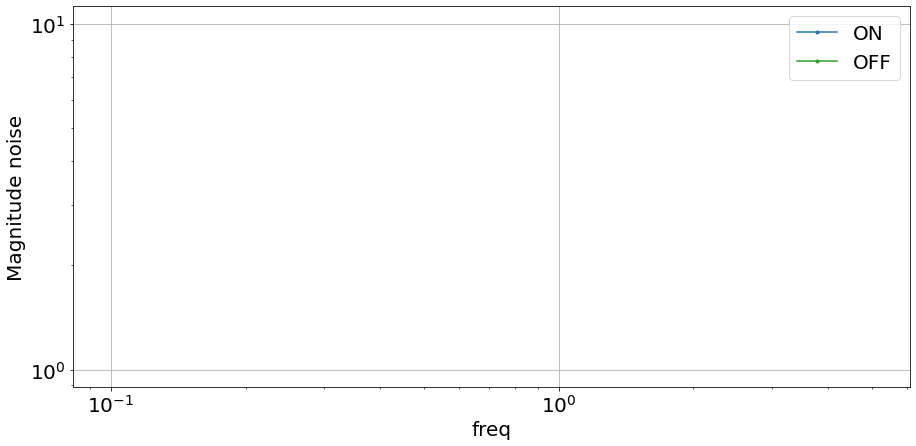

In [63]:
dc_idx = 4
pp_idx = 22
pf_idx = 2

hz1_idx = 60

selected_gain_point = data_gain[dc_idx, pp_idx, pf_idx]
selected_pha_point = data_pha[dc_idx, pp_idx, pf_idx]
print(selected_gain_point)

font = {'size'   : 20}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(1, 1, figsize = (15, 7), sharex = True)
ax.grid()
ax.set_xlabel('freq')
ax.set_ylabel('Magnitude noise')


ax.loglog(fft_freq[51:], selected_pha_point[0,51:], '.-', label = 'ON')

ax.loglog(fft_freq[hz1_idx], selected_pha_point[0,hz1_idx], '.')

ax.loglog(fft_freq[51:], selected_pha_point[1,51:], '.-', label = 'OFF')
ax.legend()

data_gain[dc_idx, pp_idx, pf_idx]


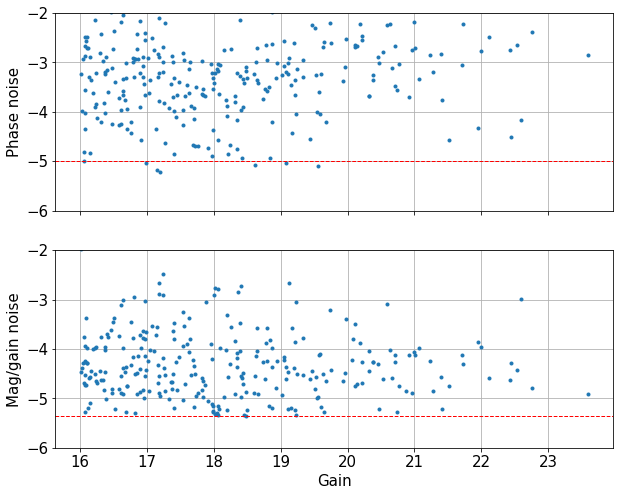

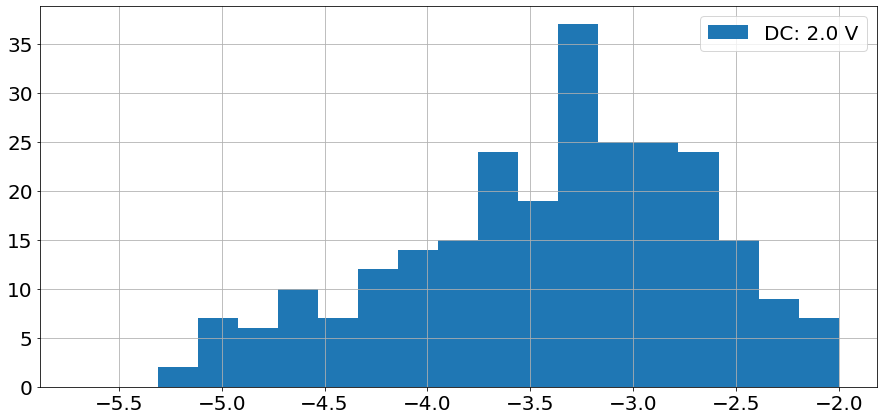

In [64]:
# critical point scearch

font = {'size'   : 15}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(2, 1, figsize=(10,8), sharex=True)

# fig1, ax1 = plt.subplots(1, 1, figsize = (15, 7), sharex = True)
# ax1.grid()
# ax1.set_xlabel('freq')
# ax1.set_ylabel('Phase noise')



def linear_func(x, a, b):
    return a * x + b

def linear_fit(x, y):
    popt, pcov = curve_fit(linear_func, x, y)
    a = popt[0]
    b = popt[1]
    return a, b


hz1_idx = 60

gain_arr = np.array([])
mag_1hz_arr = np.array([])
mag_1hz_arr_ref = np.array([])

pha_1hz_arr = np.array([])
pha_1hz_arr_ref = np.array([])

font = {'size'   : 20}
matplotlib.rc('font', **font)
fig2, ax2 = plt.subplots(1, 1, figsize=(15,7))
ax2.grid(True)
bin_edges = np.linspace(-5.7, -2, 20)

pha_1hz_arr_DC = np.array([])
pha_1hz_arr_DC_fr = np.array([]) 

for pf_idx in range(len(pump_freqs)):  
    for dc_idx in range(len(data_gain)):
        for pp_idx in range(len(pump_powers)):

            selected_gain_point = data_gain[dc_idx,pf_idx, pp_idx]
            selected_mag_point = data_mag[dc_idx,pf_idx, pp_idx]
            selected_pha_point = data_pha[dc_idx,pf_idx, pp_idx]

            if selected_mag_point[0,hz1_idx] != 0: 
                gain_arr = np.append(gain_arr, selected_gain_point)
                
                x = fft_freq[51:]
                y = selected_mag_point[0,51:]
                am, bm = linear_fit(np.log10(x[:-30]), np.log10(y[:-30]))
                
                y = selected_pha_point[0,51:]
                ap, bp = linear_fit(np.log10(x[:-30]), np.log10(y[:-30]))
                
                mag_1hz_arr = np.append(mag_1hz_arr, np.power(10, linear_func(np.log10(1), am, bm)))
                mag_1hz_arr_ref = np.append(mag_1hz_arr_ref, selected_mag_point[1,hz1_idx])
                
                pha_1hz_arr = np.append(pha_1hz_arr, np.power(10, linear_func(np.log10(1), ap, bp)))
                
                pha_1hz_arr_DC = np.append(pha_1hz_arr_DC, np.power(10, linear_func(np.log10(1), ap, bp)))
                pha_1hz_arr_DC_fr = np.append(pha_1hz_arr_DC_fr, pump_freqs[pf_idx])
                    
                pha_1hz_arr_ref = np.append(pha_1hz_arr_ref, selected_pha_point[1,hz1_idx])
                
    
if len(pha_1hz_arr_DC)>10:
    ax2.hist(np.log10(pha_1hz_arr_DC), bins=bin_edges, alpha=1, label=r'DC: {} V'.format(np.round(volts[dc_idx],2)))

                
#             if selected_gain_point>5 and selected_gain_point<5.15:
#                 x = fft_freq[51:]
#                 y = selected_pha_point[0,51:]
                
#                 a, b = linear_fit(np.log(x[:-30]), np.log(y[:-30]))
                
#                 ax1.loglog(x, y, '.-', label = r'G = {}, a = {}'.format(np.round(selected_gain_point,1), np.round(a,2)))
#                 ax1.loglog(x[:-30], np.exp(linear_func(np.log(x[:-30]), a, b)), color='black', alpha = 0.8, markersize=1, ls=":")
#                 ax1.legend()



ax[0].plot(gain_arr, np.log10(pha_1hz_arr), '.', label = 'All points')

ax[1].plot(gain_arr, np.log10(mag_1hz_arr/np.power(10, gain_arr / 10)), '.', label = 'All points')

ax[0].axhline(y=-5, color='r', linestyle='--', linewidth=1)
ax[1].axhline(y=-5.35, color='r', linestyle='--', linewidth=1)

ax[0].set_ylim(-6,-2)
ax[1].set_ylim(-6,-2)

ax[0].set_ylabel('Phase noise')

ax[1].set_xlabel('Gain')
ax[1].set_ylabel('Mag/gain noise')

ax[0].grid()
ax[1].grid()

# ax[0].legend(loc = 0)
ax2.legend()
# ax[1].legend(loc = 0)

Text(0, 0.5, 'Phase noise')

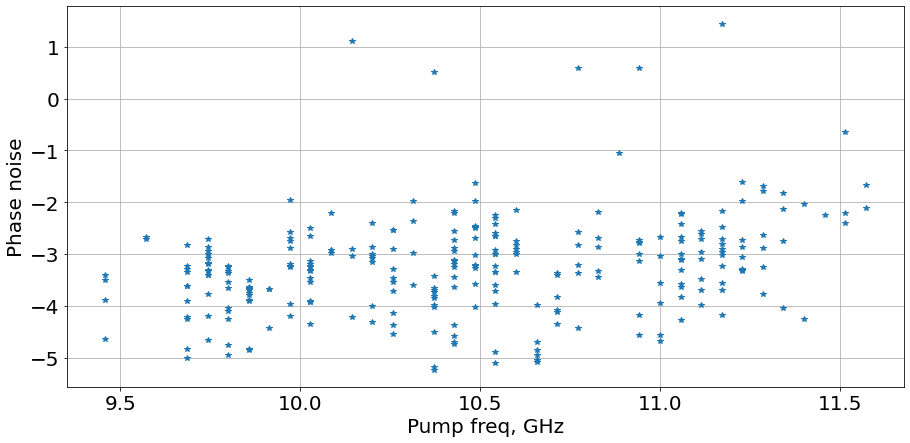

In [65]:
font = {'size'   : 20}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(1, 1, figsize=(15,7))
ax.plot(pha_1hz_arr_DC_fr/1e9, np.log10(pha_1hz_arr_DC), "*")
ax.grid()
ax.set_xlabel('Pump freq, GHz')
ax.set_ylabel('Phase noise')

IndexError: index 9 is out of bounds for axis 2 with size 9

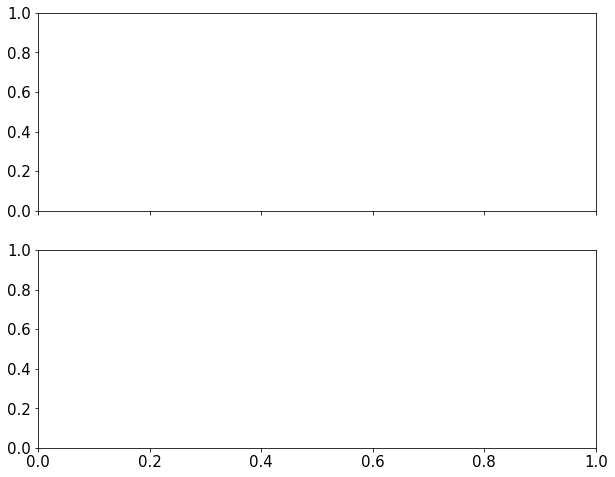

In [44]:
# critical point scearch

font = {'size'   : 15}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(2, 1, figsize=(10,8), sharex=True)


def linear_func(x, a, b):
    return a * x + b

def linear_fit(x, y):
    popt, pcov = curve_fit(linear_func, x, y)
    a = popt[0]
    b = popt[1]
    return a, b


hz1_idx = 60

gain_arr = np.array([])
mag_1hz_arr = np.array([])
mag_1hz_arr_ref = np.array([])

pha_1hz_arr = np.array([])
pha_1hz_arr_ref = np.array([])

pp_power = np.array([])

for dc_idx in range(len(data_gain)):
    for pp_idx in range(len(data_gain[0])):
        for pf_idx in range(len(data_gain[0,0])):

            selected_gain_point = data_gain[dc_idx, pp_idx, pf_idx]
            selected_mag_point = data_mag[dc_idx, pp_idx, pf_idx]
            selected_pha_point = data_pha[dc_idx, pp_idx, pf_idx]

            if selected_mag_point[0,hz1_idx] != 0: 
                gain_arr = np.append(gain_arr, selected_gain_point)
                
                x = fft_freq[51:]
                y = selected_mag_point[0,51:]
                am, bm = linear_fit(np.log(x[:-30]), np.log(y[:-30]))
                
                y = selected_mag_point[1,51:]
                am_ref, bm_ref = linear_fit(np.log(x[:-30]), np.log(y[:-30]))
                
                y = selected_pha_point[0,51:]
                ap, bp = linear_fit(np.log(x[:-30]), np.log(y[:-30]))
                
                y = selected_pha_point[1,51:]
                ap_ref, bp_ref = linear_fit(np.log(x[:-30]), np.log(y[:-30]))
                
                mag_1hz_arr = np.append(mag_1hz_arr, np.exp(linear_func(np.log(1), am, bm)))
                mag_1hz_arr_ref = np.append(mag_1hz_arr_ref, np.exp(linear_func(np.log(1), am_ref, bm_ref)))
                
                pha_1hz_arr = np.append(pha_1hz_arr, np.exp(linear_func(np.log(1), ap, bp)))
                pha_1hz_arr_ref = np.append(pha_1hz_arr_ref, np.exp(linear_func(np.log(1), ap_ref, bp_ref)))
                
                pp_power = np.append(pp_power, pump_powers[pf_idx])
    


ax[0].plot(gain_arr, np.log10(pha_1hz_arr), '.', label = 'All points')

ax[1].plot(gain_arr, np.log10(mag_1hz_arr/np.power(10, gain_arr / 10)),
                              '.', label = 'All points')

# ax[0].axhline(y=-5, color='r', linestyle='--', linewidth=1)
# ax[1].axhline(y=-5.35, color='r', linestyle='--', linewidth=1)

# ax[0].set_ylim(-0.5,2)
# ax[1].set_ylim(-0.5,2)

ax[0].set_ylabel('Phase noise')

ax[1].set_xlabel('Gain')
ax[1].set_ylabel('Mag/gain noise')

ax[0].grid()
ax[1].grid()

# ax[0].legend(loc = 0)
# ax[1].legend(loc = 0)

In [45]:
pha_1hz_arr_ref.shape

(1,)

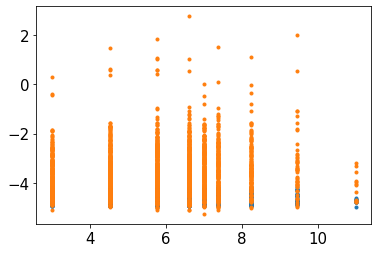

In [49]:
plt.plot(pp_power, np.log10(pha_1hz_arr_ref), '.')
plt.plot(pp_power, np.log10(pha_1hz_arr), '.')

In [9]:
max_index = np.unravel_index(np.argmax(data_gain), data_gain.shape)
best_gain_DC = max_index[0]
best_gain_pf = max_index[1]
best_gain_pp = max_index[2]
print(max_index)
data_gain[best_gain_DC, best_gain_pf, best_gain_pp]

(3, 25, 6)


24.10563

[1.2 1.3 1.4 1.5 1.6 1.7 1.8]


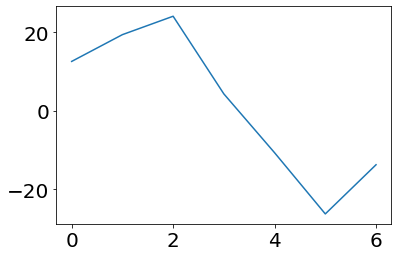

In [10]:
plt.plot(data_gain[best_gain_DC-2:best_gain_DC+5, best_gain_pf, best_gain_pp])
print(volts[best_gain_DC-2:best_gain_DC+5])

[6.62107086 7.         7.37892914 8.23114441 9.4528113 ]


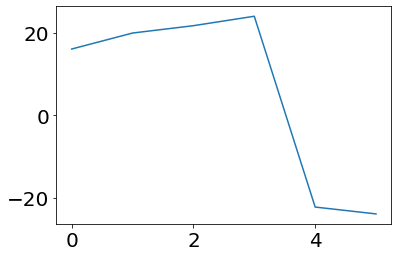

In [11]:
plt.plot(data_gain[best_gain_DC, best_gain_pf, best_gain_pp-3:best_gain_pp+6])
print(pump_powers[best_gain_pp-3:best_gain_pp+2])

[10.   10.05 10.1  10.15 10.2  10.25 10.3  10.35]


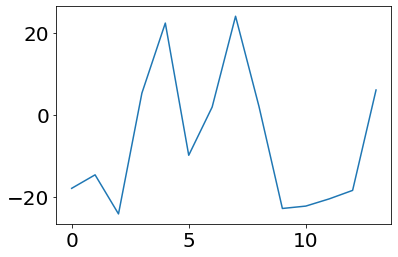

In [12]:
plt.plot(data_gain[best_gain_DC, best_gain_pf-7:best_gain_pf+7, best_gain_pp])
print(pump_freqs[best_gain_pf-5:best_gain_pf+3]/1e9)

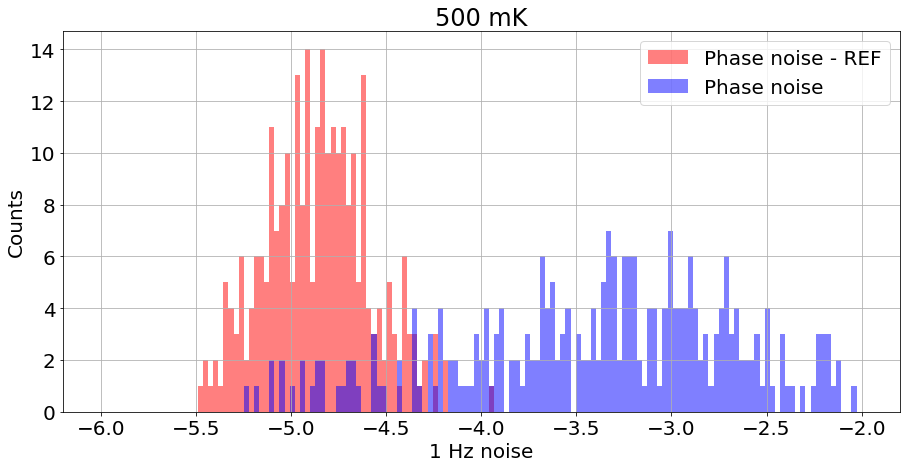

In [66]:
font = {'size'   : 20}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(1, 1, figsize=(15,7))
ax.set_title("500 mK")
ax.set_ylabel("Counts")
ax.set_xlabel("1 Hz noise")


bin_edges = np.linspace(-6, -2, 150)

# ax.hist(np.log10(pha_1hz_arr)/np.log10(pha_1hz_arr_ref), bins=bin_edges, alpha=0.5, label='Phase noise/REF', color='blue')
ax.hist(np.log10(pha_1hz_arr_ref), bins=bin_edges, alpha=0.5, label='Phase noise - REF', color='red')
ax.hist(np.log10(pha_1hz_arr), bins=bin_edges, alpha=0.5, label='Phase noise', color='blue')


ax.legend()
ax.grid(True)

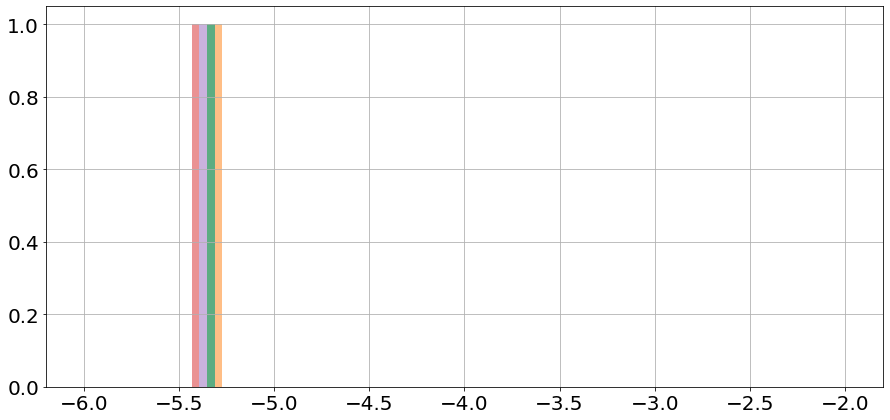

In [67]:
font = {'size'   : 20}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(1, 1, figsize=(15,7))
ax.grid(True)
bin_edges = np.linspace(-6, -2, 100)

for i in range(5):
    ax.hist(np.log10(pha_1hz_arr_ref[i]), bins=bin_edges, alpha=0.5, label='Phase noise - REF')
